First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/mfinzi/equivariant-MLP.git

# Getting Started with Equivariant Representations

Our general approach to equivariance is centered around the idea of _representations_, a prescription of how a group element acts on a given vector space.

Given a vector space $V$ and a group $G$, elements of the group $g\in G$ can act on a vector $v\in V$ by the representation matrix $v\mapsto \rho(g)v$. The vector space $V$ and the matrix $\rho$ are often referred to interchangeably as the representation.

For example with the cyclic translation group $\mathbb{Z}_4$, we implement a (faithful) base representation $V$ which cyclicly translates the elements. Sampling an arbitrary transformation, we have

In [1]:
from emlp.solver.representation import V,sparsify_basis
from emlp.solver.groups import Z,S,SO,O,O13,SO13,RubiksCube
import jax.numpy as jnp
import numpy as np

In [2]:
G=Z(4)
rep = V(G)
v = np.random.randn(rep.size())
g = G.sample()
print(f"𝜌(g) =\n{rep.rho(g)}")
print(f"v = {v}")
print(f"𝜌(g)v = {rep.rho(g)@v:}")

𝜌(g) =
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
v = [1.49013809 2.09202065 1.2159864  1.66514631]
𝜌(g)v = [2.0920208 1.2159864 1.6651464 1.490138 ]


The symmetric subspace of the representation is the space of solutions to the constraint $\forall g\in G: \ \ \rho(g)v=v$.
For any representation, you can get the basis $Q \in \mathbb{R}^{n\times r}$ for this symmetric subspace with `rep.symmetric_basis()` and the matrix $P=QQ^T$ which projects to this subspace with `rep.symmetric_projector()`.

For example, we can find invariant vectors of the cyclic translation group $\mathbb{Z}_n$ which is just the constant $\vec{1}$ scaled to have unit norm.

In [3]:
V(Z(5)).symmetric_basis()

DeviceArray([[0.44721365],
             [0.44721362],
             [0.44721365],
             [0.44721365],
             [0.44721365]], dtype=float32)

## The Representation Type System

Each implemented group comes with a faithful 'base' representation $V$. Because faithful representations are one-to-one, we can build any representation by transforming this base representation.

We provide several operators to transform and construct representations in different ways built and later go on to show how to do this more generally. In our type system, representations can be combined with the direct sum $\rho_a \oplus\rho_b$ operator, the tensor product $\rho_a\otimes\rho_b$, the dual $\rho^*$ and these operators are implemented as the python operators `+`, `*`, and `.T`.

In [4]:
V+V,  V*V,  V.T

((V+V), V⊗V, V*)

We can combine and use these operators interchangeably:

In [5]:
(V+V.T)*(V*V.T+V)

(V+V*)⊗(V⊗V*+V)

We use the shorthand $cV$ to mean $V\oplus V\oplus...\oplus V$ and $V^c = V\otimes V\otimes...\otimes V$. Note that this differs from the common notation where $V^c$ denotes the cartesian products the set (like with $\mathbb{R}^c$) which would be the same as $cV$ in this notation. Being more formal we could distinguish the two by denoting $V^{\otimes c}=V\otimes V\otimes...\otimes V$ but to stay consistent with the python interface, we will not.

In [6]:
5*V*2

(V+V+V+V+V+V+V+V+V+V)

In [7]:
2*V**3

(V⊗V⊗V+V⊗V⊗V)

When a particular symmetry group is specified, the representation can be collapsed down to a more compact form:

In [8]:
G=O(4)
2*V(G)**3

2V³

In [9]:
(2*V**3)(G)

2V³

Although for groups like the Lorentz group $SO(1,3)$ with non orthogonal representations, a distinction needs to be made between the representation and it's dual. In both cases the representation is converted down to a canonical form (but the ordering you gave is preserved as a permutation).

In [10]:
V(SO(3)).T+V(SO(3))

2V

In [11]:
V(SO13()).T+V(SO13())

V+V*

Linear maps from $V_1\rightarrow V_2$ have the type $V_2\otimes V_1^*$. The `V>>W` is shorthand for `W*V.T` and produces linear maps from `V` to `W`.

Imposing (cyclic) Translation Equivariance $G=\mathbb{Z}_n$ on linear maps $V\rightarrow V$ yields circular convolutions (circulant matrices) which can be expressed as a linear combination of $n$ basis elements of size $n\times n$.

## Exploring and Visualizing Equivariant Bases

In [12]:
G = Z(6)
repin = V(G)
repout = V(G)
conv_basis = (repin>>repout).symmetric_basis()
print(f"Conv basis has shape {conv_basis.shape}")

(36, 6)


While we provide an orthogonal basis, these bases are not always easy to make sense of as an array of numbers (any rotation of an orthogonal basis is still an orthogonal basis)

In [13]:
conv_basis[:,0]

DeviceArray([-0.00200776, -0.25157794,  0.31927773,  0.0072209 ,
             -0.03698727,  0.00357165,  0.00357159, -0.00200781,
             -0.25157797,  0.31927782,  0.00722108, -0.03698722,
             -0.03698726,  0.00357183, -0.00200774, -0.2515779 ,
              0.31927767,  0.00722109,  0.00722104, -0.03698728,
              0.00357171, -0.00200778, -0.25157782,  0.31927767,
              0.3192777 ,  0.00722104, -0.03698733,  0.00357174,
             -0.00200774, -0.2515779 , -0.25157785,  0.3192777 ,
              0.00722107, -0.03698731,  0.00357177, -0.0020077 ],            dtype=float32)

To more easily visualize the result, we can define the following function which projects a random vector and then plots components with the same values as different colors, arranged in a desired shape.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def vis_basis(basis,shape,cluster=True):
    Q=basis@jnp.eye(basis.shape[-1]) # convert to a dense matrix if necessary
    v = np.random.randn(Q.shape[0])  # sample random vector
    v = Q@(Q.T@v)                    # project onto equivariant subspace
    if cluster: # cluster nearby values for better color separation in plot
        v = KMeans(n_clusters=Q.shape[-1]).fit(v.reshape(-1,1)).labels_
    plt.imshow(v.reshape(shape))
    plt.axis('off')

def vis(repin,repout,cluster=True):
    Q = (repin>>repout).symmetric_basis() # compute the equivariant basis
    vis_basis(Q,(repout.size(),repin.size()),cluster) # visualize it

Our convolutional basis is the familiar (circulant) convolution matrix.

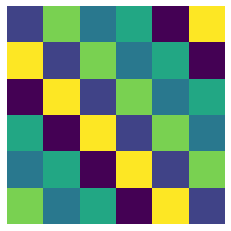

In [15]:
vis_basis(conv_basis,(repin.size(),repout.size()))

2D translation equivariange $G=\mathbb{Z}_n\times \mathbb{Z}_n$ yields 2D convolutions (bicurculant matrices)

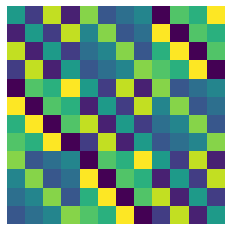

In [16]:
G = Z(3)*Z(4) #[Not recommended way of building product groups, there is a faster path described later]
repin = V(G)
repout = V(G)
vis(repin,repout)

How about the permutation group $G=S_n$, where the vector space $V$ represents a set of elements? In deep sets it was shown there are only two basis elements for equivariant linear maps $V\rightarrow V$.

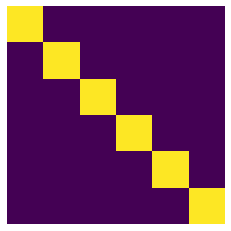

In [17]:
repin = V(S(6))
repout = V(S(6))
vis(repin,repout)

What about graphs, which are composed both of sets as well as adjacency matrices or graph laplacians? These matrices are examples of objects from $V\otimes V$ with $G=S_n$, and in Invariant and Equivariant Graph Networks () it was shown through a challenging proof that there are at most 15 basis elements which were derived analytically. We can solve for them here:

(1296, 15)


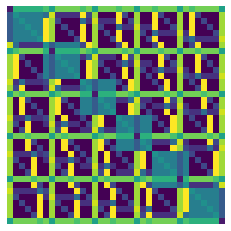

In [18]:
repin = V(S(6))**2
repout = V(S(6))**2
vis(repin,repout)
print(f"Basis matrix of shape {(repin>>repout).symmetric_basis().shape}")

How about the continuous $2$D rotation group $SO(3)$? It's well known that the only equivariant object for the vector space $V^{\otimes 3}$ is the Levi-Civita symbol $\epsilon_{ijk}$. Since the values are both $0$, positive, and negative (leading to more than `Q.shape[-1]` clusters) we disable the clustering.

Basis matrix of shape (27, 1)


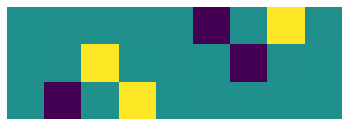

In [19]:
W = V(SO(3))
repin = W**2
repout = W
Q = (repin>>repout).symmetric_basis()
print(f"Basis matrix of shape {Q.shape}")
vis(repin,repout,cluster=False)

In [20]:
print(sparsify_basis(Q).reshape(3,3,3))

[[[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0. -1.  0.]]

 [[ 0.  0. -1.]
  [ 0.  0.  0.]
  [ 1.  0.  0.]]

 [[ 0.  1.  0.]
  [-1.  0.  0.]
  [ 0.  0.  0.]]]


We can also solve for very high dimensional representations which we automatically switch to using the automated iterative Krylov subspace method

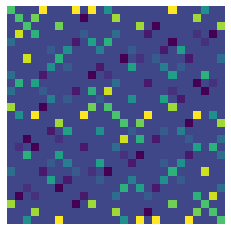

In [21]:
vis(W**3,W**3)

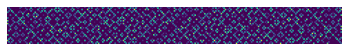

In [22]:
vis(W**5,W**3)

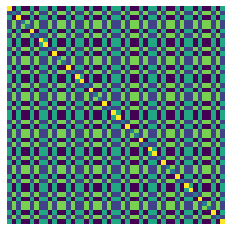

In [23]:
vis(V(RubiksCube()),V(RubiksCube()))

## Composite Representations and Lazy Matrices

How about maps from graphs to sets? Lets say a graph consists of one node feature and one edge feature which can be represented with the $\oplus$ operator.

(252, 7)


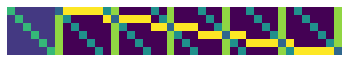

In [24]:
W = V(S(6))
repin = W+W**2 # (one set feature and one edge feature)
repout = W     # (one set feature)
vis(repin,repout)
print(f"Basis matrix of shape {(repin>>repout).symmetric_basis().shape}")

Representations that have many copies or multiplicity of a given representation type, such as for the many channels in a neural network, are simply examples of the $\oplus$ operator (`+` in python). The `rep.symmetric_basis()` and `rep.symmetric_projector()` can return lazy matrices $Q$ and $P=QQ^T$ when the representations are composite (or when the representation is specified lazily). These Lazy matrices are modeled after [scipy LinearOperators](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html). By exploiting structure in the matrices via fast matrix vector multiplies (MVMs), it can be possible to work with extremely large matrices.

For example with a more realistically sized layer with 100 global constants, 100 set feature channels, and 20 edge feature channels ($100V^0+100V^1+20V^2$) we have

In [25]:
W = V(S(6))
repin = 100*W**0 + 100*W+20*W**2
repout = repin
rep_map = repin>>repout
print(f"{rep_map}, of size {rep_map.size()}")

Q = rep_map.symmetric_basis()
print(f"Basis matrix of shape {Q.shape}")

10000V⁰+20000V+14000V²+4000V³+400V⁴, of size 2016400
Basis matrix of shape (2016400, 84000)


Unfortunately the larger matrices are harder to visualize as for the matrix above we need 84000 different colors! We are happy to field suggestions for visualizing very large bases.

(-0.5, 1419.5, 1419.5, -0.5)

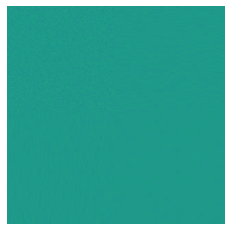

In [26]:
P =rep_map.symmetric_projector()
v = np.random.randn(P.shape[-1])
v = P@v
plt.imshow(v.reshape(repout.size(),repin.size()))
plt.axis('off');

# Constructing Equivariant Models

Previously we showed examples of finding equivariant bases for different groups and representations, now we'll show how these bases can be assembled into equivariant neural networks such as EMLP. 

We will give examples at a high level showing how the specific EMLP model can be applied to different groups and input-output types, and later in a lower level showing how models like EMLP can be constructed with equivariant layers and making use of the equivariant bases.

## Using EMLP with different groups and representations (high level)

![ex 2.13](imgs/EMLP_fig.png)

A basic EMLP is a sequence of EMLP layers (containing G-equivariant linear layers, bilinear layers incorporated with a shortcut connection, and gated nonlinearities. While our numerical equivariance solver can work with any finite dimensional linear representation, for EMLP we restrict ourselves to _tensor_ representations.

By tensor representations, we mean all representations which can be formed by arbitrary combinations of $\oplus$,$\otimes$,$^*$ (`+`,`*`,`.T`) of a base representation $\rho$. This is useful because it simplifies the construction of our bilinear layer, which is a crucial ingredient for expressiveness and universality in EMLP.

Following the $T_{(p,q)}=V^{\otimes p}\otimes (V^*)^{\otimes p}$ notation in the paper, we provide the convenience function for constructing higher rank tensors.

In [1]:
from emlp.solver.representation import V
from emlp.solver.groups import SO13

def T(p,q=0):
    return (V**p*V.T**q)

print(T(2,3))
print(T(2,3)(SO13()))

V⊗V⊗V*⊗V*⊗V*
V²⊗V*³


Lets get started with a toy dataset: learning how an inertia matrix depends on the positions and masses of 5 point masses distributed in different ways. The data consists of mappings (positions, masses) --> (inertia matrix) pairs, and has an $G=O(3)$ symmetry (3D rotation and reflections). If we rotate all the positions, the resulting inertia matrix should be correspondingly rotated.

In [2]:
from emlp.models.datasets import Inertia
from emlp.solver.groups import SO,O,S,Z
trainset = Inertia(1000) # Initialize dataset with 1000 examples
testset = Inertia(2000)
G = SO(3)
print(f"Input type: {trainset.rep_in(G)}, output type: {trainset.rep_out(G)}")

Input type: 5V⁰+5V, output type: V²


For convenience, we store in the dataset the types for the input and the output. `5V⁰` are the $5$ mass values and `5V` are the position vectors of those masses, `V²` is the matrix type for the output, equivalent to $T_2$. To initialize the [EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.models.mlp.html#emlp.models.EMLP), we just need these input and output representations, the symmetry group, and the size of the network as parametrized by number of layers and number of channels (the dimension of the feature representation).

In [3]:
from emlp.models.mlp import EMLP,MLP
model = EMLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=384)
# uncomment the following line to instead try the MLP baseline
#model = MLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=384)

## Example Objax Training Loop

We build our EMLP model with [objax](https://objax.readthedocs.io/en/latest/) because we feel the object oriented design makes building complicated layers easier. Below is a minimal training loop that you could use to train EMLP.

In [4]:
BS=500
lr=3e-3
NUM_EPOCHS=500

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from jax import vmap

opt = objax.optimizer.Adam(model.vars())

@objax.Function.with_vars(model.vars())
def loss(x, y,training=True):
    yhat = model(x, training=training)
    return ((yhat-y)**2).mean()

gv = objax.GradValues(loss, model.vars())

@objax.Function.with_vars(model.vars()+opt.vars())
def train_op(x, y, lr):
    g, v = gv(x, y)
    opt(lr=lr, grads=g)
    return v

train_op = objax.Jit(train_op)
test_loss = objax.Jit(objax.ForceArgs(loss, training=False))

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [5]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch%10:
        test_losses.append(np.mean([test_loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))

  0%|          | 0/500 [00:00<?, ?it/s]

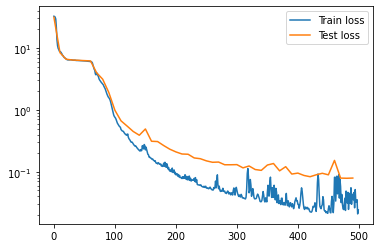

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

In [7]:
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

rin,rout = trainset.rep_in(G),trainset.rep_out(G)

def equivariance_err(mb):
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

As expected, the network continues to be equivariant as it is trained.

In [8]:
print(f"Average test equivariance error {np.mean([equivariance_err(mb) for mb in testloader]):.2e}")

Average test equivariance error 4.83e-07


## Breaking EMLP down into equivariant layers (mid level)

Internally for EMLP, we use representations that [uniformly allocate dimensions](https://emlp.readthedocs.io/en/latest/package/emlp.models.mlp.html#emlp.models.uniform_rep) between different tensor representations.

In [9]:
from emlp.models.mlp import uniform_rep
r = uniform_rep(512,G)
print(r)

122V⁰+40V+12V²+3V³+V⁴


Below is a trimmed down version of EMLP, so you can see how it is built from the component layers `LieLinear`, `BiLinear`, and `GatedNonlinearities`. These layers can be constructed like ordinary objax modules, using the input and output representations.

In [10]:
from objax.module import Module
from emlp.models.mlp import Sequential,LieLinear,BiLinear,GatedNonlinearity,gated

class EMLPBlock(Module):
    """ Basic building block of EMLP consisting of G-Linear, biLinear,
        and gated nonlinearity. """
    def __init__(self,rep_in,rep_out):
        super().__init__()
        rep_out_wgates = gated(rep_out)
        self.linear = LieLinear(rep_in,rep_out_wgates)
        self.bilinear = BiLinear(rep_out_wgates,rep_out_wgates)
        self.nonlinearity = GatedNonlinearity(rep_out)
    def __call__(self,x):
        lin = self.linear(x)
        preact =self.bilinear(lin)+lin
        return self.nonlinearity(preact)

class EMLP(Module):
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        reps = [rep_in(group)]+num_layers*[uniform_rep(ch,group)]
        self.network = Sequential(
            *[EMLPBlock(rin,rout) for rin,rout in zip(reps,reps[1:])],
            LieLinear(reps[-1],rep_out(group))
        )
    def __call__(self,x,training=True):
        return self.network(x)

The representations of the hidden layers (taking place of the number of channels in a standard MLP) is by default given by this `uniform_rep` shown above. Unlike this pedagogical implementation you can specify the representation of the hidden layers directly in the [full EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.models.mlp.html#emlp.models.EMLP) by feeding in a representation to the `ch` argument, or even a list of representations to specify each hidden layer.

Note that since we are using the `GatedNonlinearity`, additional scalar gate channels need to be added to the output representation for the layer directly before the nonlinearity (in this case the `LieLinear` layer) which can be achieved with the `gated` function.

## The equivariant linear layers (low level)

At a lower level, the implementation of the `LieLinear` is fairly straightforward. An unconstrained bias `b` and weight matrix `w` are initialized. The projection matrices $P_b$ and $P_w$ are computed which are used project onto the symmetric subspace for each. Finally, during the forward pass, the unconstrained parameters are reshaped to vectors, projected via the matrices, and reshaped back to the original sizes. Then these projected parameters are applied to the input like a standard linear layer.

In [ ]:
class LieLinear(Module):
    """ Basic equivariant Linear layer from repin to repout."""
    def __init__(self, repin, repout):
        nin,nout = repin.size(),repout.size()
        self.b = TrainVar(objax.random.uniform((nout,))/jnp.sqrt(nout))
        self.w = TrainVar(orthogonal((nout, nin)))
        self.rep_W = rep_W = repout*repin.T
        
        self.Pb = repout.symmetric_projector() # the bias vector has representation repout
        self.Pw = rep_W.symmetric_projector()
        
    def __call__(self, x):
        W = (self.Pw@self.w.value.reshape(-1)).reshape(*self.w.value.shape)
        b = self.Pb@self.b.value
        return x@W.T+b

# Implementing a New Group

Implementing a new group equivariance in our library is fairly straightforward. 
You need to specify the discrete and continuous generators of the group in a given representation: $\rho(h_i)$ and $d\rho(A_k)$, and then call the init method. These two fields, `self.discrete_generators` and `self.lie_algebra` should be a sequence of square matrices. These can either be specified as dense arrays (such as through `np.ndarray`s of size `(M,n,n)` and `(D,n,n)`) or as `LinearOperator` objects that implement matmul lazily. In general it's possible to implement any matrix group, and we'll go through a few illustrative examples. After checking out these examples, you can browse through the implementations for many other groups [here](https://github.com/mfinzi/equivariant-MLP/blob/master/emlp/solver/groups.py).

## Discrete Group Example: Alternating Group $A_n$

The alternating group $A_n$ is a discrete group that contains all _even_ permutations from the permutation group $S_n$. There are many different generating sets that we could use, but let's for example choose the [generators](https://math.stackexchange.com/questions/1358030/set-of-generators-for-a-n-the-alternating-group) $(123),(124),...,(12n)$ where each term is a cyclic permutation of those indices. So to implement the group, all we need to do is specify these generators.

In [5]:
#import logging; logging.getLogger().setLevel(logging.INFO)
from emlp.solver.groups import Group,S
from emlp.solver.representation import V,T,vis
import numpy as np

class Alt(Group): 
    """ The alternating group in n dimensions"""
    def __init__(self,n):
        assert n>2
        self.discrete_generators = np.zeros((n-2,n,n))+np.eye(n) # init an array of n-2 identity matrices
        for i in range(n-2):
            ids = (0,1,i+2)
            permed_ids = np.roll(ids,1) # cyclic permutation (0,1,i+2)->(i+2,0,1)
            self.discrete_generators[i,ids] = self.discrete_generators[i,permed_ids]
        super().__init__(n)

High rank objects for $Alt(n)$ have additional equivariant solutions compared to the permutation group $S_n$ that contains it.

In [2]:
print("T5 basis for Alt(5) of shape ",T(5)(Alt(5)).symmetric_basis().shape)
print("T5 basis for S(5) of shape ",T(5)(S(5)).symmetric_basis().shape)

T5 basis for Alt(5) of shape  (3125, 63)
T5 basis for S(5) of shape  (3125, 52)


You can verify the equivariance:

In [3]:
from emlp.tests.equivariant_subspaces_tests import rel_error
G = Alt(5)
rep = T(5)(G)
Q = rep.symmetric_basis()
gQ = rep.rho(G.sample())@Q
rel_error(Q,gQ)

DeviceArray(1.0878562e-06, dtype=float32)

## Continuous Group Example: Special Orthogonal Group $\mathrm{SO}(n)$

Many Lie groups lie in the image of the exponential map. A classic example is the special orthogonal group $SO(n)$ consisting of rotations in $n$ dimensions: $\mathrm{SO}(n) = \{R \in \mathbb{R}^{n\times n}: R^TR=I, \mathrm{det}(R)=1\}$. Because this is a continuous group, we need to specify the Lie Algebra, which can be found by differentiating the constraints at the identity or simply by looking it up on [wikipedia](https://en.wikipedia.org/wiki/3D_rotation_group#Lie_algebra). $\mathfrak{so}(n) = T_\mathrm{id}\mathrm{SO}(n) = \{A\in \mathbb{R}^{n\times n}: A^\top=-A \}$. We can choose any basis for this $n(n-1)$ dimensional subspace of antisymmetric matrices. Since $\mathrm{exp}(\mathfrak{so}(n)) = \mathrm{SO}(n)$, this is all we need to specify.

In [4]:
class SO(Group): #
    def __init__(self,n):
        """ The special orthogonal group SO(n) in n dimensions"""
        self.lie_algebra = np.zeros(((n*(n-1))//2,n,n))
        k=0
        for i in range(n):
            for j in range(i):
                self.lie_algebra[k,i,j] = 1
                self.lie_algebra[k,j,i] = -1
                k+=1
        super().__init__(n)

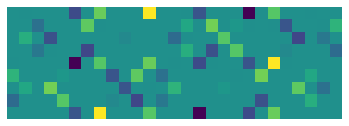

In [5]:
vis(V(SO(3))**3,V(SO(3))**2,cluster=False)

## Lie Group with Multiple Connected Components Example: $\mathrm{O}(n)$ 

Lie groups that are not in the image of the exponential map can be a bit more complicated because they often need to be constructued with both continuous and discrete generators. A good example is the orthogonal group $\mathrm{O}(n)$ consisting of rotations and reflections $\mathrm{O}(n) = \{R \in \mathbb{R}^{n\times n}: R^TR=I\}$. The Lie algebra for $\mathrm{O}(n)$ is the same as for $\mathrm{SO}(n)$. $\mathfrak{o}(n)=\mathfrak{so}(n)$ and so $\mathrm{exp}(\mathfrak{o}(n)) = \mathrm{SO}(n) \ne \mathrm{O}(n)$. Instead, the orthogonal group has $2$ connected components: orthogonal matrices with $\mathrm{det}(R)=1$ and $\mathrm{det}(R)=-1$, and so we need a generator to traverse between the two components such as $h = \begin{bmatrix}-1 &0\\ 0 & I\\
\end{bmatrix}$. We can reuse the Lie algebra implementation from $\mathrm{SO}(n)$ and implement the additional discrete generator below.

In [6]:
class O(SO): #
    def __init__(self,n):
        """ The Orthogonal group O(n) in n dimensions"""
        self.discrete_generators = np.eye(n)[None]
        self.discrete_generators[0,0,0]=-1
        super().__init__(n)

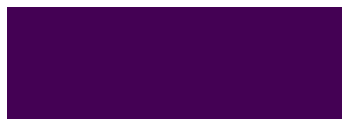

In [7]:
vis(V(O(3))**3,V(O(3))**2,cluster=False); #Unlike SO(n), O(n) has no solutions for odd parity V^3->V^2 = T5 = odd

## Accelerating the solver using lazy matrices

For larger representations our solver uses an iterative method that benefits from faster multiplies with the generators. Instead of specifying the generators using dense matrices, you can specify them as `LinearOperator` objects in a way that makes use of known structure (like sparsity, permutation, etc). These LinearOperator objects are modeled after [scipy Linear Operators](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html) but adapted to be compatible with jax and with some additional features.

Returning to the alternating group example, we can specify the generators as permutation operators directly. There are many useful LinearOperators implemented in `LinearOperator` which we recommend using if available, but we will go through the minimum steps for implementing a new operator like Permutation as an example.

Note that you need to be using quite large representations before any speedups will be felt due to the increased compile times with Jax (we are hoping to speed this up).

In [1]:
from emlp.solver.linear_operator_jax import LinearOperator
import numpy as np

class LazyPerm(LinearOperator):
    def __init__(self,perm):
        self.perm=perm
        self.shape = (len(perm),len(perm))
    def _matmat(self,V):
        return V[self.perm]
    def _matvec(self,V):
        return V[self.perm]
    def _adjoint(self):
        return LazyPerm(np.argsort(self.perm))

In [2]:
class AltFast(Group): 
    """ The alternating group in n dimensions"""
    def __init__(self,n):
        assert n>2
        perms =np.zeros((n-2,n)).astype(int)+np.arange(n)[None]
        for i in range(n-2):
            ids = (0,1,i+2)
            permed_ids = np.roll(ids,1) # cyclic permutation (0,1,i+2)->(i+2,0,1)
            perms[i,ids] = perms[i,permed_ids]
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)

In [3]:
#import logging; logging.getLogger().setLevel(logging.INFO)

In [6]:
%timeit -n1 -r1 T(2)(Alt(100)).symmetric_basis()

Krylov Solving for Equivariant Subspace r<=10:   0%|          | 0/100 [00:00<?, ?it/s]

17.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%timeit -n1 -r1 T(2)(AltFast(100)).symmetric_basis()

Krylov Solving for Equivariant Subspace r<=10:   0%|          | 0/100 [00:00<?, ?it/s]

29.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Implementing New Representations

As our solver treats objects very generally, implementing new representations is surprisingly easy. To implement a new [Representation](https://emlp.readthedocs.io/en/latest/package/emlp.solver.representation.html#emlp.models.solver.representation.Rep) you need to implement `size()` which is the dimension of the representation, `rho(M)` which is a mapping from the group elements to the representation matrix, as well `__eq__` and `__hash__` to distinguish different representations. It's also a good idea to implement a `__str__` function to improve readability. All representations implemented this way should have the `.G` attribute specifying the symmetry group.

The implementation also requires you to specify whether the representation is regular (whether `rho(M)` outputs a permutaiton matrix) with the `is_regular` attribute, and also the `.T` property that returns the dual of the representation. We plan on removing these two requirements in a later release.

## Example 1: Irreducible Representations of SO(2) 

As a first example, we show one can implement the real irreducible representations of the group SO(2). All of irreducible representations $\psi_n$ of SO(2) are $2$-dimensional (except for $\psi_0$ which is the same as [Scalar](https://emlp.readthedocs.io/en/latest/package/emlp.solver.representation.html#emlp.models.solver.representation.Scalar) $= \mathbb{R} = \psi_0$). These representations can be written $\psi_n(R_\theta) = \begin{bmatrix}\cos(n\theta) &\sin(n\theta)\\-\sin(n\theta) &  \cos(n\theta) \end{bmatrix}$ or simply: $\psi_n(R) = R^n$.

In [70]:
import jax.numpy as jnp
from emlp.solver.representation import Rep,vis
from emlp.solver.groups import SO

class SO2Irreps(Rep):
    """ (Real) Irreducible representations of SO2 """
    is_regular=False
    def __init__(self,order):
        assert order>0, "Use Scalar for 𝜓₀"
        self.G=SO(2)
        self.order = order
    def size(self):
        return 2
    def rho(self,M):
        return jnp.linalg.matrix_power(M,self.order)
    def __str__(self):
        number2sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
        return f"𝜓{self.order}".translate(number2sub)
    def __eq__(self,other):
        return type(self)==type(other) and self.G==other.G and self.order==other.order
    def __hash__(self):
        return hash((type(self),self.G,self.order))
    @property
    def T(self):
        return self

That's it! Now we can use the SO(2) irreps in the type system, and solve for equivariant bases that contain them.

In [71]:
psi1 = SO2Irreps(1)
psi2 = SO2Irreps(2)
psi3 = SO2Irreps(3)
psi4 = SO2Irreps(4)

In [72]:
psi1*psi2+psi3

𝜓₃+𝜓₂⊗𝜓₁

We can verify [schur's lemma](https://en.wikipedia.org/wiki/Schur%27s_lemma), that there are no nontrivial equivariant linear maps from one irrep to another:

In [60]:
print((psi1>>psi2).symmetric_basis(),(psi2>>psi3).symmetric_basis(),(psi1>>psi3).symmetric_basis())

[] [] []


And we can include non irreducibles in our representation too. For example computing equivariant maps from $T_4 \rightarrow \psi_2$.

𝜓₂⊗V⁴ equivariant maps with r=8 basis elements


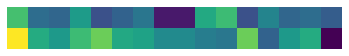

In [113]:
vis(V(SO(2))**4,psi2,False)
Wrep = V(SO(2))**4>>psi2
print("{} equivariant maps with r={} basis elements".format(Wrep,Wrep.symmetric_basis().shape[-1]))

## Example 2: PseudoScalars, PseudoVectors, ...

With a slightly more sophisticated example, we'll now implement the representations known as [PseudoScalars](https://en.wikipedia.org/wiki/Pseudoscalar), [PseudoVectors](https://en.wikipedia.org/wiki/Pseudovector), and other PseudoTensor representations. These representations commonly occur in physics when working with cross products or the Hodge star, and also describe the Fermi statistics of spin 1/2 particles that are antisymmetric under exchange.

A pseudoscalar is like a scalar `Scalar` $=\mathbb{R}$, but incurs a $-1$ under orientation reversing transformations: $\rho(M) = \mathrm{sign}(\mathrm{det}(M))$. Similarly, pseudovectors are like ordinary vectors but can pick up this additional $-1$ factor. In fact, we can convert any representation into a pseudorepresentation by multiplying by a pseudoscalar.

<!-- For when the group $G$ is the symmetric group $S_n$, the sign of the determinant of the permutation matrices $\sigma\in G$ is nothing but the parity of the permutation $(-1)^{N(\sigma)}$ -->

In [139]:
from emlp.solver.representation import Rep,V,T,vis,Scalar

In [155]:
class PseudoScalar(Rep):
    is_regular=False
    def __init__(self,G=None):
        self.G=G
    def __call__(self,G):
        return PseudoScalar(G)
    def size(self):
        return 1
    def __str__(self):
        return "P"
    def rho(self,M):
        sign = jnp.linalg.slogdet(M@jnp.eye(M.shape[0]))[0]
        return sign*jnp.eye(1)
    def __eq__(self,other):
        return type(self)==type(other) and self.G==other.G
    def __hash__(self):
        return hash((type(self),self.G))
    @property
    def T(self):
        return self

In [166]:
G = S(4)
P = PseudoScalar(G)
W = V(G)

We can then build up pseudotensors with multiplication. As expected pseudovectors incur a -1 for odd permutations.

In [178]:
pseudovector = P*W
g = G.sample()
print(f"Sample g = \n{g}")
print(f"Pseudovector 𝜌 = \n{pseudovector.rho_dense(g)}")

Sample g = 
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
Pseudovector 𝜌 = 
[[-1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]]


Again, we can freely mix and match these new representations with existing ones.

In [180]:
P*(W**2 +P)+W.T

P²+V+P⊗V²

Equivariant maps from matrices to pseodovectors yield a different set of solutions from maps from matrices to vectors.

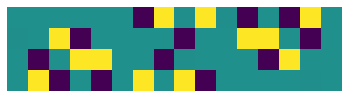

In [181]:
vis(W**2,pseudovector,cluster=False)

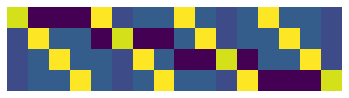

In [185]:
vis(W**2,W,cluster=False)

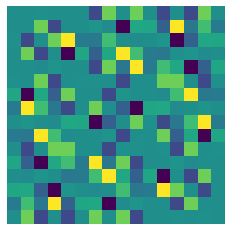

In [196]:
vis(P*W**2,W**2,cluster=False)

We can even mix and match with the irreducible representations above.

In [227]:
P = PseudoScalar(SO(2))
W = V(SO(2))
rep = psi2>>P*W**2
print(rep)
print(rep.symmetric_basis().shape)

P⊗𝜓₂⊗V²
(8, 2)


## Additional Information 

Several other functions may be optionally implemented to improve performance such as the Lie Algebra representation `drho(A)` which by default is calculated automatically from `rho` as $d\rho(A) := d\rho(M)|_{M=I}(A) = \frac{d}{dt} \rho(e^{tA})|_{t=0}$, the dual representation `.T`. However, these functions are optional and the representation can function fine without them.

# Combining Representations from Different Groups (experimental)
## Direct Product groups

It is possible to combine representations from different groups. These kinds of representations are relevant when there are multiple structures in the data. For example, a point cloud is a set of vectors which transforms both under permutations and rotations of the vectors. We can formalize this as $V_{S_n}\otimes V_{SO(3)}$ or in tensor notation $T_1^{S_n}\otimes T_1^{SO(3)}$. While this object could be expressed as the representation of the product group $V_{S_n \times SO(3)}$, other objects like $T_k^{S_n}\otimes T_j^{SO(3)}$ can not be so easily.

Nevertheless, we can calculate the symmetric bases for these objects. For example, maps from vector edge features $T_1^{SO(3)}\otimes T_2^{S_n}$ to matrix node features $T_2^{SO(3)}\otimes T_1^{S_n}$ can be computed:

In [1]:
from emlp.solver.groups import *
from emlp.solver.representation import T,vis,V,Scalar

repin,repout = T(1)(SO(3))*T(2)(S(4)),T(2)(SO(3))*T(1)(S(4))
print(repin,"-->", repout)

V²_S(4)⊗V_SO(3) --> V_S(4)⊗V²_SO(3)


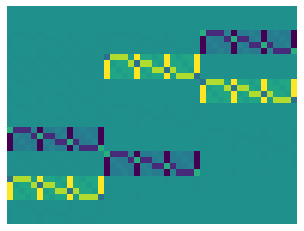

In [7]:
vis(repin,repout,cluster=False)

Or perhaps you would like equivariant maps from two sequence of sets and a matrix (under 3D rotations) to itself. You can go wild.

In [2]:
rep = 2*T(1)(Z(3))*T(1)(S(4))+T(2)(SO(3))
print(f"Rep: {rep}")
print(f"Linear maps: {rep>>rep}")

Rep: V²+2V_S(4)⊗V_Z(3)
Linear maps: V⁴+4V_S(4)⊗V_Z(3)⊗V²_SO(3)+4V²_S(4)⊗V²_Z(3)


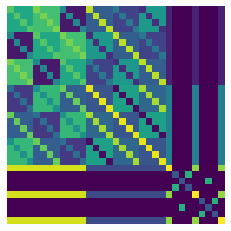

In [7]:
vis(rep,rep)

The kronecker product of the individual solutions for different groups can be seen in these basis matrices, in the top left hand corner we have a circulant matrix of deep set solutions (identity + background)

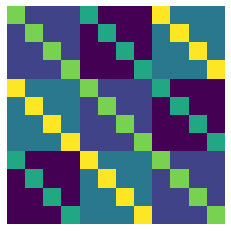

In [3]:
vis(V(Z(3))*V(S(4)),V(Z(3))*V(S(4)))

And in the bottom left we have maps $V_{Z_3}\otimes V_{S_4} \rightarrow V_{SO(2)}^{\otimes 2}$ of which the solutions are the product of $V_{Z_3}\otimes V_{S_4} \rightarrow \mathbb{R}$ (the vector $\mathbf{1}$) and $\mathbb{R} \rightarrow V_{SO(2)}^{\otimes 2}$ (the flattened $I_{3\times 3}$)

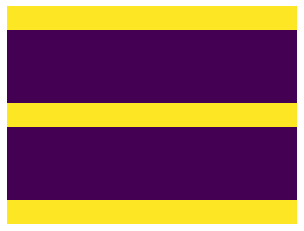

In [5]:
vis(V(Z(3))*V(S(4)),T(2)(SO(3)),False)

## Wreath Products (coming soon)

These are all examples of tensor products of representations, which are in turn a kind of representation on the direct product group $G=G_1\times G_2$. There are other ways of combining groups however, and for many hierarchical structures there is a larger group of symmetries $G_1\wr G_2$ that contains $G_1 \times G_2$ but also other elements. These so called wreath products in the very nice paper [Equivariant Maps for Hierarchical Structures](https://arxiv.org/pdf/2006.03627.pdf). Support for the wreath product of representations is not yet implemented but if this is something that would be useful to you, send me an email.

# Multilinear Maps

Our codebase extends trivially to multilinear maps, since these maps are in fact just linear maps in disguise.

If we have a sequence of representations $R_1$, $R_2$, $R_3$ for example, we can write the (bi)linear maps $R_1\rightarrow R_2\rightarrow R_3$. This way of thinking about maps of multiple variables borrowed from programming languages and curried functions is very powerful.

We can think of such an object $R_1\rightarrow R_2\rightarrow R_3$ either as $R_1 \rightarrow (R_2\rightarrow R_3)$: a linear map from $R_1$ to linear maps from $R_2$ to $R_3$ or as
$(R_1\times R_2) \rightarrow R_3$: a bilinear map from $R_1$ and $R_2$ to $R_3$. Since linear maps from one representation to another are just another representation in our type system, you can use this way of thinking to find the equivariant solutions to arbitrary multilinear maps.

For example, we can get the bilinear $SO(4)$ equivariant maps $(R_1\times R_2) \rightarrow R_3$ with the code below.

In [1]:
from emlp.solver.groups import SO,rel_err
from emlp.solver.representation import V

G = SO(4)
W = V(G)
R1 = 3*W+W**2 # some example representations
R2 = W.T+W**0
R3 = W**0 +W**2 +W

Q = (R1>>(R2>>R3)).symmetric_basis()
print(Q.shape)

(2940, 27)


And we can verify that these multilinear solutions are indeed equivariant

In [2]:
import numpy as np

example_map = (Q@np.random.randn(Q.shape[-1]))
example_map = example_map.reshape(R3.size(),R2.size(),R1.size())

x1 = np.random.randn(R1.size())
x2 = np.random.randn(R2.size())
g = G.sample()

out1 = np.einsum("ijk,j,k",example_map,R2.rho(g)@x2,R1.rho(g)@x1)
out2 = R3.rho(g)@np.einsum("ijk,j,k",example_map,x2,x1)
rel_err(out1,out2)

DeviceArray(1.9872947e-07, dtype=float32)

Note that the output mapping is of shape $(\mathrm{dim}(R_3),\mathrm{dim}(R_2),\mathrm{dim}(R_1))$
with the inputs to the right as you would expect with a matrix. 

Note the parenthesis in the expression `(R1>>(R2>>R3))` since the python `>>` associates to the right.
The notation $R_1\rightarrow R_2 \rightarrow R_3$ or `(R1>>(R2>>R3))` can be a bit confusing since the inputs are on the right. It can be easier in this concept to instead reverse the arrows and express the same object as $R_3\leftarrow R_2\leftarrow R_1$ or `R3<<R2<<R1` (with no parens required) that matches the axis ordering of the multilinear map (tensor). 

You can use `R2<<R1` in place of `R1>>R2` wherever you like, and it is usually more intuitive.

In [3]:
R3<<R2<<R1 == (R1>>(R2>>R3))

True

# Limited Pytorch Support

We strongly recommend that users of our libary write native Jax code. However, we understand that due to existing code and/or constraints from the employer, it is sometimes unavoidable to use other frameworks like PyTorch. 

To service these requirements, we have added a way that PyTorch users can make use of the equivariant bases $Q\in \mathbb{R}^{n\times r}$ and projection matrices $P = QQ^\top$ that are computed by our solver. Since these objects are implicitly defined through `LinearOperators`, it is not as straightforward as simply calling `torch.from_numpy(Q)`. However, there is a way to use these operators within PyTorch code while preserving any gradients of the operation. We provide the function `emlp.solver.pytorch_support.torchify_fn` to do this.

In [1]:
import torch
import jax
import jax.numpy as jnp
from emlp.solver.representation import V
from emlp.solver.groups import S

W =V(S(4))
rep = 3*W+W**2

In [2]:
Q = (rep>>rep).symmetric_basis()
P = (rep>>rep).symmetric_projector()

In [3]:
applyQ = lambda v: Q@v
applyP = lambda v: P@v

The key is to wrap the desired operations as a function, and then we can apply `torchify_fn`. Now instead of taking jax objects as inputs and outputing jax objects, these functions take in PyTorch objects and output PyTorch objects.

In [4]:
from emlp.solver.pytorch_support import torchify_fn
applyQ_torch = torchify_fn(applyQ)
applyP_torch = torchify_fn(applyP)

In [5]:
x_torch = torch.arange(Q.shape[-1]).float().cuda()
x_torch.requires_grad=True
x_jax  = jnp.asarray(x_torch.cpu().data.numpy()) 

In [6]:
Qx1 = applyQ(x_jax)
Qx2 = applyQ_torch(x_torch)
print("jax output: ",Qx1[:5])
print("torch output: ",Qx2[:5])

jax output:  [0.48484263 0.07053992 0.07053989 0.07053995 1.6988853 ]
torch output:  tensor([0.4848, 0.0705, 0.0705, 0.0705, 1.6989], device='cuda:0',
       grad_fn=<SliceBackward>)


The outputs match, and note that the torch outputs will be on whichever is the default jax device. Similarly, the gradients of the two objects also match:

In [7]:
torch.autograd.grad(Qx2.sum(),x_torch)[0][:5]

tensor([-2.8704,  2.7858, -2.8704,  2.7858, -2.8704], device='cuda:0')

In [8]:
jax.grad(lambda x: (Q@x).sum())(x_jax)[:5]

DeviceArray([-2.8703732,  2.7858496, -2.8703732,  2.7858496, -2.8703732],            dtype=float32)

So you can safely use these torchified functions within your model, and still compute the gradients correctly.